<font size =8> Barnacle Detection by Training a Model
<font size =4>

In this experiment, I will tune a large pre-trained model. YOLO11 model is known for having exceptional object detection and counting abilities. By training it on a dataset of just Barnacles, I optimize its capabilities for the specific task of counting barnacles. I obtained the datatset of Barnacles from [Roboflow Universe](https://universe.roboflow.com/), world's largest collection of open source computer vision datasets and APIs.

In [15]:
import matplotlib.pyplot as plt
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
import fiftyone as fo 
from fiftyone.core.labels import Detections
import ipywidgets
from PIL import Image
import numpy as np

<font size =5>Training and initializing the model 

<font size =4> The YOLO model was trained using a Barnacle Detection dataset for 40 epochs on Google Collab. The best weight  were downloaded and stored in the best.pt file in this directory. The YOLO11 model uses this set of weights for the inference section. If interested on the specifics of the training, you can check out the YOLO11.ipynb notebook, or the Training_Results directory. Below is an image illustrating the training process.


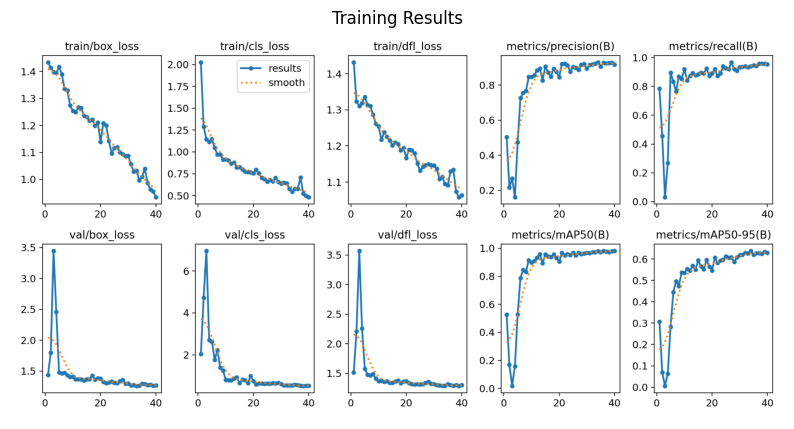

In [16]:
img = np.asarray(Image.open("Training_Results/YOLO11/results.png"))
plt.figure(figsize=(10, 10))
plt.title("Training Results")
plt.axis("off")
plt.imshow(img)
plt.show()


<font size = 6>Initializing model 

Here I initialize the model using Sahi's AutoDetectionModel. The model uses updated weights from the trainingdone on the Barnacle Datatset

In [17]:

model = AutoDetectionModel.from_pretrained(
        model_type = "ultralytics", 
        model_path = 'Training_Results/YOLO11/best.pt', 
        confidence_threshold=0.3, 
        device ="cpu")
    

def sahi_inference(image_filepath): 
    
    result = get_sliced_prediction(
        'images/sample_image.png',
        model, slice_height=256,
        slice_width=256,
        postprocess_match_metric="IOU",
        postprocess_match_threshold=0.4,
        overlap_height_ratio=0.2,
        postprocess_class_agnostic = True,
        overlap_width_ratio=0.2,
        )
    return result



<font size = 5> Creating Fiftyone Dataset to measure performance

<font size = 4> Fiftyone is a multimodal data platform for Computer Vision. I came across it as I was looking for ways to assess the performance of the model robustly. I use fiftyone because I had recently used scikit and COCO and wanted to try something new out. I also read that fiftyone lets you visualize the dataset using a GUI which sounded cool. It took me quite some time to get hang of this but I liked it. 

In [18]:
DATASET_NAME = "barnacle"
if fo.dataset_exists(DATASET_NAME):
    print(f"Deleting existing dataset: '{DATASET_NAME}'")
    fo.delete_dataset(DATASET_NAME)
    print(f"Dataset '{DATASET_NAME}' deleted successfully.")
else:
    print(f"Dataset '{DATASET_NAME}' does not exist (or was already deleted).")

Deleting existing dataset: 'barnacle'
Dataset 'barnacle' deleted successfully.


In [19]:
#keeping persistent as false meanns
dataset= fo.Dataset.from_images_dir("images", 
                                    name = "barnacle", 
                                    persistent = False)


 100% |█████████████████████| 2/2 [22.7ms elapsed, 0s remaining, 87.9 samples/s]     


07/26/2025 17:13:30 - INFO - eta.core.utils -    100% |█████████████████████| 2/2 [22.7ms elapsed, 0s remaining, 87.9 samples/s]     


<font size = 5>Adding Ground Truths and Predictions in the dataset 



<font size = 4> In this step, I create ground truth labellings for the fiftyone dataset. To do so, I will be performing Connected Componenets Analysis on the image masks for each sample, iterate through all the detected masks, and create bounding boxes for the masks.These will later be used for accuracy analysis methods like IoU calculation. 

In [20]:
import fiftyone as fo
import fiftyone.utils.data as fou 
import cv2 
import numpy as np 
import os

IMAGE_DIR = "images" 
MASK_DIR = "masks"   

GROUND_TRUTH_FIELD = "ground_truth" 



if GROUND_TRUTH_FIELD not in dataset.get_field_schema():
    print(f"Adding ground truth masks to the '{GROUND_TRUTH_FIELD}' field...")
    
    #manually mapping the images to their masks because only two so convenient
    filename_mapping = {
        "sample_image.png":"mask1.png", 
        "sample_image2.png":"mask2.png"
    }


    for sample in dataset:   #Prepare masks for each image in the dataset
        img_filename = os.path.basename(sample.filepath)
        mask_filename = filename_mapping.get(img_filename) # handles cases where an image might not have a mask
        mask_path = os.path.join(MASK_DIR, mask_filename)

        if not os.path.exists(mask_path):
            print(f"Warning: Mask not found at {mask_path} for {img_filename}. Skipping ground truth for this sample.")
            continue

        # Use cv2.IMREAD_GRAYSCALE to ensure it's loaded as a single channel
        gt_mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        
        if gt_mask_image is None:
            print(f"Error: Could not load mask image from {mask_path}. Skipping ground truth.")
            continue

        # Binarizing
        _, binary_mask = cv2.threshold(gt_mask_image, 1, 255, cv2.THRESH_BINARY)

        # Connected component analysis
        num_labels, labels_img, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, 8, cv2.CV_32S)

        gt_detections = []

        for i in range(1, num_labels):
            # Create a boolean mask for the current instance
            instance_mask = (labels_img == i) 

            y_coords, x_coords = np.where(instance_mask)
            
            # Skip mask if empty 
            if y_coords.size == 0:
                continue

            x_min, x_max = x_coords.min(), x_coords.max()
            y_min, y_max = y_coords.min(), y_coords.max()

            img_height, img_width = gt_mask_image.shape[:2]
            
            bbox_width = max(1, x_max - x_min + 1)
            bbox_height = max(1, y_max - y_min + 1)

            rel_bounding_box = [
                x_min / img_width,
                y_min / img_height,
                bbox_width / img_width,
                bbox_height / img_height
            ]

            cropped_mask = instance_mask[y_min:y_max+1, x_min:x_max+1]

            gt_detections.append(
                fo.Detection(
                    label="barnacle",
                    bounding_box=rel_bounding_box,
                    mask=cropped_mask.astype(bool)  
                )
            )

        sample[GROUND_TRUTH_FIELD] = fo.Detections(detections=gt_detections)
        sample.save()

    print(f"Ground truth masks added to the '{GROUND_TRUTH_FIELD}' field for all samples.")
else:
    print(f"Field '{GROUND_TRUTH_FIELD}' already exists. Skipping ground truth addition.")

print(dataset)
#Sanity Check 
sample = dataset.first()
has_gt = sample.ground_truth is not None and len(sample.ground_truth.detections) > 0
print(f"Sample 1 has ground truth: {has_gt}")
print("-------------------------------------------------------------------------------------------------------------------------------------")


Adding ground truth masks to the 'ground_truth' field...
Ground truth masks added to the 'ground_truth' field for all samples.
Name:        barnacle
Media type:  image
Num samples: 2
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
Sample 1 has ground truth: True
-------------------------------------------------------------------------------------------------------------------------------------


<font size =4> Here, I add the predictions made by my model to the dataset. By looping over the images, my model performs SAHI inference on the models, extrats the results, converts it into the format for fiftyone detection objects and saves the results under  "PREDICTIONS_FIELDS" in the dataset 

In [21]:
PREDICTIONS_FIELD= "predictions"
if PREDICTIONS_FIELD not in  dataset.get_field_schema():
    print(f"\nRunning model inference and adding predictions to the '{PREDICTIONS_FIELD}' field...")

    for sample in dataset:
        model_output_preds = sahi_inference(sample.filepath) 

        # Convert raw model output into FiftyOne Detection objects
        fo_predictions = model_output_preds.to_fiftyone_detections()
        sample[PREDICTIONS_FIELD] = fo.Detections(detections=fo_predictions)
        sample.save() # Saving changes 

    print(f"Model predictions added to the 'predictions' field for all samples.")
else:
    print(f"Field 'predictions' already exists. Skipping prediction addition.")

print(dataset)
#sanity check
print(f"Sample 1 has predictions field: {'predictions' in dataset.first().field_names}")
# for intelligibility
print("--------------------------------------------------------------------------------------------------------------------------------------")



Running model inference and adding predictions to the 'predictions' field...
Performing prediction on 49 slices.
Performing prediction on 49 slices.
Model predictions added to the 'predictions' field for all samples.
Name:        barnacle
Media type:  image
Num samples: 2
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    predictions:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
Sample 1 has predictions field: True
---------------------------

<font size =4>Run evaluations using the predictions and the ground-truth labels calculated above. Do it for several different IoU values for a more comprehensive analysis 

In [22]:
results = dataset.evaluate_detections(
    PREDICTIONS_FIELD,
    gt_field = GROUND_TRUTH_FIELD, 
    eval_key = "sahi_evaluation", 
    method = "coco", 
    iou = 0.25, 
    compute_mAP= True
)

Evaluating detections...


07/26/2025 17:14:35 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████████| 2/2 [9.7m elapsed, 0s remaining, 0.0 samples/s]   


07/26/2025 17:24:15 - INFO - eta.core.utils -    100% |█████████████████████| 2/2 [9.7m elapsed, 0s remaining, 0.0 samples/s]   


Performing IoU sweep...


07/26/2025 17:24:15 - INFO - fiftyone.utils.eval.coco -   Performing IoU sweep...


 100% |█████████████████████| 2/2 [4.8s elapsed, 0s remaining, 0.4 samples/s]   


07/26/2025 17:24:20 - INFO - eta.core.utils -    100% |█████████████████████| 2/2 [4.8s elapsed, 0s remaining, 0.4 samples/s]   


accuracy   0.42
precision  0.49
recall     0.76
fscore     0.59
support    2267


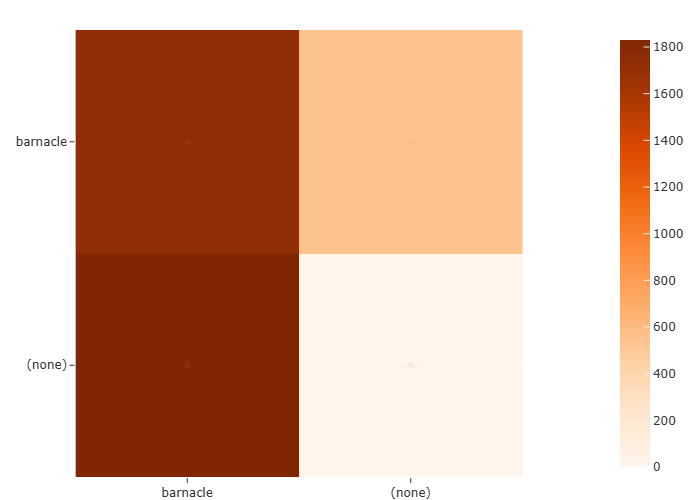

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',
              'uid': '4d2ac18e-ec4f-4c6f-8586-88008cbc6b92',
              'x': {'bdata': 'AAEAAQ==', 'dtype': 'i1'},
              'y': {'bdata': 'AAABAQ==', 'dtype': 'i1'}},
             {'colorscale': [[0.0, 'rgb(255,245,235)'], [0.125,
                             'rgb(254,230,206)'], [0.25, 'rgb(253,208,162)'],
                             [0.375, 'rgb(253,174,107)'], [0.5, 'rgb(253,141,60)'],
                             [0.625, 'rgb(241,105,19)'], [0.75, 'rgb(217,72,1)'],
                             [0.875, 'rgb(166,54,3)'], [1.0, 'rgb(127,39,4)']],
              'hoverinfo': 'skip',
              'showscale': False,
              'type': 'heatmap',
              'uid': '5b800924-ed37-4122-ac59-9c77b5c858cd',
              'z': {'bdata': 'JgcAALwGHwI=', 'dtype': 'i2', 'shape': '2, 2'},
              'zmax': np.int64(1830),
              'zmin': 0},
             {'color

In [23]:
results.print_metrics()
plot = results.plot_confusion_matrix(classes=["barnacle"])
plot.show()

In [24]:
plot.freeze()

07/26/2025 17:24:21 - INFO - choreographer.browsers.chromium -   Chromium init'ed with kwargs {}
07/26/2025 17:24:21 - INFO - choreographer.browsers.chromium -   Found chromium path: C:\Program Files\Google\Chrome\Application\chrome.exe
07/26/2025 17:24:21 - INFO - choreographer.utils._tmpfile -   Temp directory created: C:\Users\arses\AppData\Local\Temp\tmp13yg9iuo.
07/26/2025 17:24:21 - INFO - choreographer.browser_async -   Opening browser.
07/26/2025 17:24:21 - INFO - choreographer.utils._tmpfile -   Temp directory created: C:\Users\arses\AppData\Local\Temp\tmp0hfzgzop.
07/26/2025 17:24:21 - INFO - choreographer.browsers.chromium -   Temporary directory at: C:\Users\arses\AppData\Local\Temp\tmp0hfzgzop
07/26/2025 17:24:21 - INFO - kaleido.kaleido -   Conforming 1 to file:///C:/Users/arses/AppData/Local/Temp/tmp13yg9iuo/index.html
07/26/2025 17:24:21 - INFO - kaleido.kaleido -   Waiting on all navigates
07/26/2025 17:24:22 - INFO - kaleido.kaleido -   All navigates done, putting the

In [25]:
dataset = fo.load_dataset("barnacle")
session = fo.launch_app(dataset)
predictions_view = dataset.take(2)
session.view = predictions_view
session.view = None
session.show()


07/26/2025 17:24:24 - INFO - choreographer.utils._tmpfile -   TemporaryDirectory.cleanup() worked.
07/26/2025 17:24:24 - INFO - choreographer.utils._tmpfile -   shutil.rmtree worked.
